## Pneumonia Identification - A Neural Network Model

### Pneumonia infection 
Pneumonia is a common acute respiratory infectiom that affects the alveoli and distal airways. It is associated with high morbidity and is a major health problem with both short term and long term affects. Pneumonia is also widespread occuring in all parts of the globe across all age groups. It is more common in the very young (< 5 years of age) and older adults, particularly amonsgt those who suffer from other health conditions. Nearly one million children per year lose their lives to pneumonia and related causes. The causes of pneumonia have multiple vectors - viral, bacterial, and fungal. Individuals with pneumonia face both respiratory and systemic symptoms. Accurate diagnosis of the infection requires both clinical and radiological (x-ray) methods. Rapid and accurate diagnosis is also crucial to successful treatment, often with a range of antimicrobial therapies. Rapid imaging assessment is a matter of life and death.

#### Business Case - Intermountain Health Care
Intermountain Health Care (IHC) is a not-for-profit healthcare system based in Utah. Over the past several years they have been working to extend their reach to rural areas. IHC now operates nine hospitals and 23 rural community medical clinics. Despite their reach they face a shortage of medical specialists, particularly radiologists. According to the American Medical     There is a looming shortage of trained radiologists

#### Dataset Description

Data comes from.....

In [2]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os, shutil
from PIL import Image
import scipy
from scipy import ndimage

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(123)

### Notebook Data Flow

#### Load Data -->   Process Data for Modeling -->    Baseline Model -->    CNN Model 1 -->   

####        Model 2 with Data Augmentation -->    Model 3 with added layering and padding -->                                    

####        Model 4 with regularization -->    Model 5 with Batch Normalization --> Model Evaluation  --> Recommendations

## Load Data 

In [3]:
train = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', labels = 'inferred', 
                                                            class_names = ['NORMAL', 'PNEUMONIA'])

Found 5216 files belonging to 2 classes.


In [4]:
test = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/test', labels = 'inferred',
                                                          class_names = ['NORMAL', 'PNEUMONIA'])

Found 624 files belonging to 2 classes.


In [5]:
val = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/val', labels = 'inferred',
                                                         class_names = ['NORMAL', 'PNEUMONIA'])

Found 16 files belonging to 2 classes.


Pediatric Lung Image - NORMAL


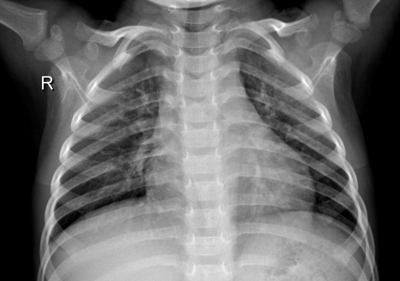

Pediatric Lung Image - PNEUMONIA (viral origins)


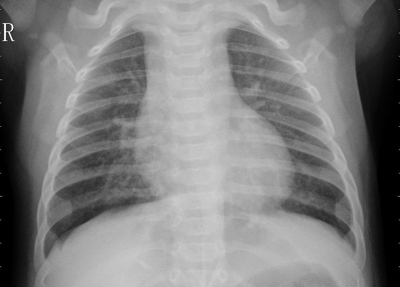

Pediatric Lung Image - PNEUMONIA (bacterial origins)


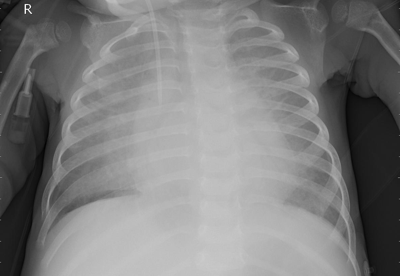

In [6]:
#Display normal lung image

print('Pediatric Lung Image - NORMAL')

norm_img = Image.open('chest_xray/train/NORMAL/IM-0125-0001.jpeg')
norm_img.thumbnail((400, 400))
display(norm_img);

# Display pneumonia image with viral origins

print('Pediatric Lung Image - PNEUMONIA (viral origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')
p_img.thumbnail((400, 400))
display(p_img);

# Display pneumonia image with bacterial origins

print('Pediatric Lung Image - PNEUMONIA (bacterial origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg')
p_img.thumbnail((400, 400))
display(p_img);


## Process the datasets for modeling

In [7]:
# Identify shape of each dataset
print('Shape and Datatype of Train dataset:', train)
print()
print('Shape and Datatype of Val dataset:', val)
print()
print('Shape and Datatype of Test dataset:', test)

Shape and Datatype of Train dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Val dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Test dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [8]:
# plot histogram showing classes - normal and pneumonia



In [9]:
#identify file path
train_folder = 'chest_xray/train'
val_folder = 'chest_xray/val'
test_folder = 'chest_xray/test'

In [10]:
# get all the data in the directory, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 624) 

# get all the data in the directory, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 16)

# get all the data in the directory, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size = 5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [11]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [12]:
train_images.shape[0]

5216

In [13]:
#reshape for deep learning
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 12288)
(624, 12288)
(16, 12288)


In [14]:
train_labels[:,0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [15]:
#reshape labels
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [16]:
train_y.shape

(5216, 1)

In [17]:
test_y.shape

(624, 1)

## 1. Build a baseline model

Build a simple baseline model using densely connected layers. 

In [18]:
# Neural network model
baseline_model = Sequential()

# No hidden layers

#Input
baseline_model.add(Dense(16, activation='relu', input_shape=(12288,))) 

# Binary output
baseline_model.add(Dense(1, activation='sigmoid'))

In [19]:
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

base_history = baseline_model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_split = 0.2)

Epoch 1/30
131/131 [==============================] - 0s 2ms/step - loss: 0.5294 - accuracy: 0.7387 - val_loss: 0.4284 - val_accuracy: 0.9119
Epoch 2/30
131/131 [==============================] - 0s 1ms/step - loss: 0.3454 - accuracy: 0.8562 - val_loss: 0.2243 - val_accuracy: 0.9176
Epoch 3/30
131/131 [==============================] - 0s 1ms/step - loss: 0.2822 - accuracy: 0.8830 - val_loss: 0.2198 - val_accuracy: 0.9282
Epoch 4/30
131/131 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9161 - val_loss: 0.1492 - val_accuracy: 0.9464
Epoch 5/30
131/131 [==============================] - 0s 1ms/step - loss: 0.2219 - accuracy: 0.9149 - val_loss: 0.1417 - val_accuracy: 0.9444
Epoch 6/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1854 - accuracy: 0.9271 - val_loss: 0.2390 - val_accuracy: 0.8908
Epoch 7/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1766 - accuracy: 0.9317 - val_loss: 0.1597 - val_accuracy: 0.9406
Epoch 

In [20]:
# Baseline training results
base_results_train = baseline_model.evaluate(train_img, train_y)

163/163 [==============================] - 0s 965us/step - loss: 0.2372 - accuracy: 0.9032


In [21]:
base_results_val = baseline_model.evaluate(val_img, val_y)

1/1 [==============================] - 0s 1ms/step - loss: 0.2537 - accuracy: 0.8750


In [22]:
#Print results for train and test
print("Baseline Results from Training Data:", base_results_train)
print()
print("Baseline Results from Validation Data:", base_results_val)



Baseline Results from Training Data: [0.23717954754829407, 0.9031825065612793]

Baseline Results from Validation Data: [0.2537093162536621, 0.875]


In [23]:
# Plot train and test loss and accuracy
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

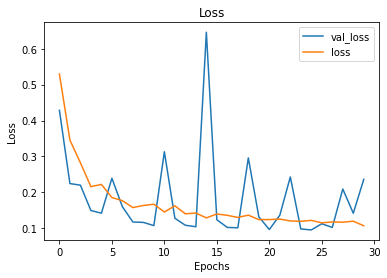

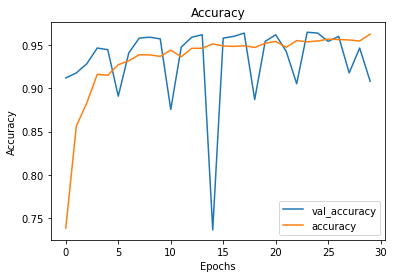

In [24]:
visualize_training_results(base_history)

#### Model Evaluation

What is going on here most likely?

## CNN Model - Model 1

Include convolution, and Dense layering - 2 hidden layers.

In [25]:
#Instantiate a CNN model

model_1 = Sequential()

# Add convolution layer

model_1.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape = (64, 64, 3)))


# Add another convolution layer

model_1.add(Conv2D(64, (3, 3), activation='relu'))


# Flatten the model

model_1.add(Flatten())

# Add dense layers, two hidden

model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(7, activation = 'relu'))
model_1.add(Dense(5, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [26]:
# Examine the built model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                14745664  
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [27]:
# Fit the model
history_1 = model_1.fit(train_images, 
                        train_y, 
                        epochs=20, 
                        validation_split = 0.2) 
                                

Epoch 1/20
131/131 [==============================] - 26s 195ms/step - loss: 0.8851 - accuracy: 0.7222 - val_loss: 0.6553 - val_accuracy: 0.7759
Epoch 2/20
131/131 [==============================] - 26s 195ms/step - loss: 0.6452 - accuracy: 0.7347 - val_loss: 0.6162 - val_accuracy: 0.7759
Epoch 3/20
131/131 [==============================] - 26s 196ms/step - loss: 0.6168 - accuracy: 0.7347 - val_loss: 0.5832 - val_accuracy: 0.7759
Epoch 4/20
131/131 [==============================] - 26s 196ms/step - loss: 0.5956 - accuracy: 0.7347 - val_loss: 0.5592 - val_accuracy: 0.7759
Epoch 5/20
131/131 [==============================] - 25s 194ms/step - loss: 0.5848 - accuracy: 0.7347 - val_loss: 0.5474 - val_accuracy: 0.7759
Epoch 6/20
131/131 [==============================] - 25s 193ms/step - loss: 0.5806 - accuracy: 0.7347 - val_loss: 0.5419 - val_accuracy: 0.7759
Epoch 7/20
131/131 [==============================] - 26s 199ms/step - loss: 0.5792 - accuracy: 0.7347 - val_loss: 0.5389 - val_ac

In [28]:
results_1_train = model_1.evaluate(train_images, train_y)

163/163 [==============================] - 5s 30ms/step - loss: 0.5702 - accuracy: 0.7429


In [29]:
results_1_test = model_1.evaluate(test_images, test_y)

20/20 [==============================] - 1s 28ms/step - loss: 0.6900 - accuracy: 0.6250


In [30]:
#Print results for Model 1 train and test
print("Model 1 Results from Training Data:", results_1_train)
print()
print("Model 1 Results from Test Data:", results_1_test)



Model 1 Results from Training Data: [0.5701866149902344, 0.7429064512252808]

Model 1 Results from Test Data: [0.6900326609611511, 0.625]


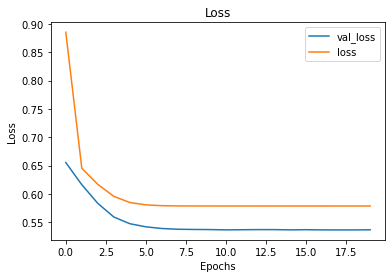

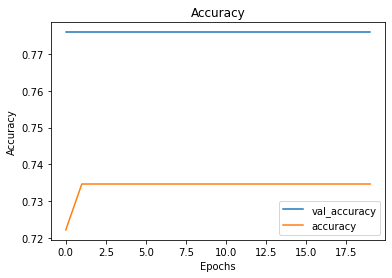

In [31]:
# Plot accuracy and loss
visualize_training_results(history_1)

#### Model Evaluation

What is going on here most likely?

## Model 2 - Data Augmentation 
Add data augmentation to account for imbalance classes. Include Maxpooling after Convolution Layers 

In [33]:
# Augment the training and test data to account for class imbalance
train_datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.1, 
                             horizontal_flip=True, 
                             fill_mode = 'nearest',
                             validation_split = 0.12)

test_datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.1, 
                             horizontal_flip=True, 
                             fill_mode = 'nearest',
                             validation_split = 0.12)

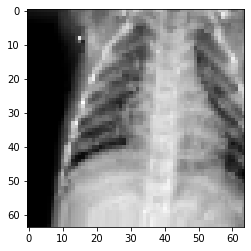

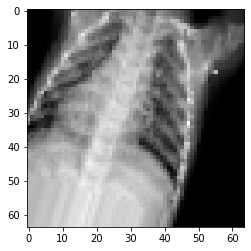

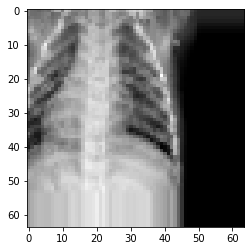

In [34]:
# View an augmented image

# Load image
img = load_img('chest_xray/train/NORMAL/IM-0125-0001.jpeg', target_size=(64, 64))

# Reshape
reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 

# Run image through augmented image generator

i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
        
plt.show()

In [35]:
# Set image size for shaping
img_size = 150

# Train generator - training subset
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size), 
        batch_size = 32, 
        class_mode='binary', 
        subset = "training")

# Validation Generator - validation subset
val_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size),
        batch_size = 32,
        class_mode='binary', 
        subset = "validation")

# Test Generator 
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(img_size, img_size), 
        batch_size = 624,
        class_mode='binary') 


Found 4591 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [36]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [37]:
train_labels.shape

(32,)

In [38]:
train_images.shape

(32, 150, 150, 3)

In [39]:
test_images.shape

(624, 150, 150, 3)

In [40]:
#Instantiate a CNN model

model_2 = Sequential()

# Add convolution layer

model_2.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolution layer

model_2.add(Conv2D(64, (4, 4), activation='relu'))

# Add another maxpooling layer

model_2.add(MaxPooling2D((2, 2)))

# Flatten the model

model_2.add(Flatten())

# Add dense layers

model_2.add(Dense(32, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2508832   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [155]:
history_2 = model_2.fit(train_generator, 
                      steps_per_epoch = 50,
                      epochs=10, 
                      validation_data = val_generator,
                      validation_steps = 10,
                      verbose = 1)

Epoch 1/10
50/50 [==============================] - 38s 761ms/step - loss: 0.3840 - accuracy: 0.8244 - val_loss: 0.4346 - val_accuracy: 0.7500
Epoch 2/10
50/50 [==============================] - 37s 745ms/step - loss: 0.3503 - accuracy: 0.8406 - val_loss: 0.3774 - val_accuracy: 0.8219
Epoch 3/10
50/50 [==============================] - 38s 758ms/step - loss: 0.3674 - accuracy: 0.8400 - val_loss: 0.4730 - val_accuracy: 0.7406
Epoch 4/10
50/50 [==============================] - 42s 833ms/step - loss: 0.3573 - accuracy: 0.8469 - val_loss: 0.4656 - val_accuracy: 0.8250
Epoch 5/10
50/50 [==============================] - 41s 813ms/step - loss: 0.3610 - accuracy: 0.8377 - val_loss: 0.9532 - val_accuracy: 0.7437
Epoch 6/10
50/50 [==============================] - 45s 898ms/step - loss: 0.3560 - accuracy: 0.8606 - val_loss: 0.3610 - val_accuracy: 0.8375
Epoch 7/10
50/50 [==============================] - 43s 853ms/step - loss: 0.3623 - accuracy: 0.8673 - val_loss: 0.3358 - val_accuracy: 0.8313

In [43]:
results_2_train = model_2.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 858us/step - loss: 0.2751 - accuracy: 0.9062


In [44]:
results_2_test = model_2.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 65ms/step - loss: 0.6513 - accuracy: 0.7196


In [45]:
results_2_val = model_2.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.3554 - accuracy: 0.8438


In [46]:
#Print results for Model 1 train and test
print("Model 2 Results from Training Data:", results_2_train)
print()
print("Model 2 Results from Test Data:", results_2_test)


Model 2 Results from Training Data: [0.2750738263130188, 0.90625]

Model 2 Results from Test Data: [0.6513449549674988, 0.7195512652397156]


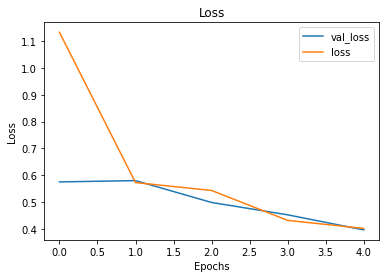

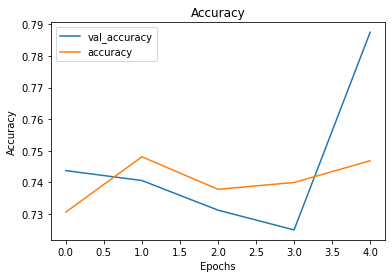

In [47]:
# Plot accuracy and loss
visualize_training_results(history_2)

In [53]:
# RMSE on test data
from sklearn.metrics import mean_squared_error

print("MEAN SQUARED ERROR:")
np.sqrt(mean_squared_error(test_labels, y_hat_test))

MEAN SQUARED ERROR:


0.7905694150420949

## Model 3 
Added Convolution and MaxPooling layers, Adam optimizer, included Padding and Stride adjustment

In [56]:
#Instantiate a CNN model

model_3 = Sequential()

# Add convolution layer

model_3.add(Conv2D(32, (3, 3), padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_3.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same'))


model_3.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(128, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(256, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

# Flatten the model

model_3.add(Flatten())

# Add dense layers

model_3.add(Dense(64, activation = 'relu'))
model_3.add(Dense(1, activation = 'sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [57]:
model_3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 256)      

In [58]:
history_3 = model_3.fit(train_generator,  
                      epochs=20, 
                      validation_data=val_generator,
                      verbose = 1) 
                      

Epoch 1/20
144/144 [==============================] - 118s 822ms/step - loss: 0.4965 - accuracy: 0.7783 - val_loss: 0.4292 - val_accuracy: 0.7856
Epoch 2/20
144/144 [==============================] - 119s 825ms/step - loss: 0.3054 - accuracy: 0.8647 - val_loss: 0.3999 - val_accuracy: 0.7856
Epoch 3/20
144/144 [==============================] - 119s 829ms/step - loss: 0.2665 - accuracy: 0.8841 - val_loss: 0.3283 - val_accuracy: 0.8464
Epoch 4/20
144/144 [==============================] - 120s 832ms/step - loss: 0.2437 - accuracy: 0.8976 - val_loss: 0.3187 - val_accuracy: 0.8304
Epoch 5/20
144/144 [==============================] - 120s 832ms/step - loss: 0.2271 - accuracy: 0.9061 - val_loss: 0.2981 - val_accuracy: 0.8656
Epoch 6/20
144/144 [==============================] - 120s 832ms/step - loss: 0.2074 - accuracy: 0.9105 - val_loss: 0.3029 - val_accuracy: 0.8416
Epoch 7/20
144/144 [==============================] - 120s 831ms/step - loss: 0.2001 - accuracy: 0.9181 - val_loss: 0.2865 -

In [59]:
results_3_train = model_3.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 853us/step - loss: 0.0794 - accuracy: 0.9688


In [60]:
results_3_test = model_3.evaluate(test_images, test_labels)

20/20 [==============================] - 3s 130ms/step - loss: 0.6402 - accuracy: 0.7997


In [61]:
results_3_val = model_3.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 796us/step - loss: 0.1751 - accuracy: 0.9375


In [62]:
#Print results for Model 1 train and test
print("Model 3 Results from Training Data:", results_3_train)
print()
print("Model 3 Results from Test Data:", results_3_test)


Model 3 Results from Training Data: [0.07937262952327728, 0.96875]

Model 3 Results from Test Data: [0.6401925683021545, 0.7996794581413269]


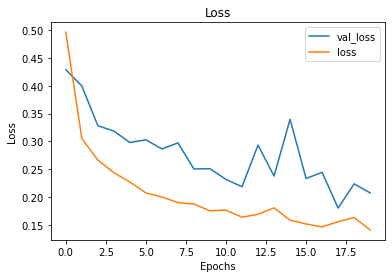

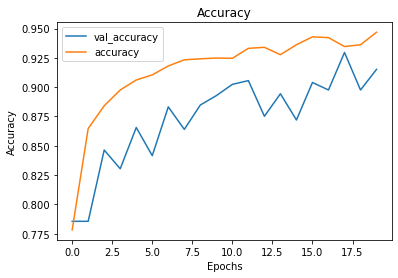

In [63]:
# Plot accuracy and loss
visualize_training_results(history_3)

In [149]:
# Generate predictions

predictions = model_3.predict(test_images)
#y_hat_test.reshape(1,-1)[0]
predictions[:10]

array([[0.99994636],
       [0.9998379 ],
       [0.15772185],
       [0.9999386 ],
       [0.9999576 ],
       [0.8291179 ],
       [0.07593858],
       [0.9978753 ],
       [0.99989045],
       [0.9495258 ]], dtype=float32)

In [150]:
y_hat_test = np.round(predictions)

In [151]:
y_hat_test[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [152]:
# RMSE on test data
from sklearn.metrics import mean_squared_error

print("MEAN SQUARED ERROR:")
np.sqrt(mean_squared_error(test_labels, y_hat_test))

MEAN SQUARED ERROR:


0.45113817

In [153]:
# Display confusion matrix

print('Confusion Matrix')
print(confusion_matrix(test_labels, y_hat_test))

Confusion Matrix
[[115 119]
 [  8 382]]


In [154]:
#print(classification_report(test_y, predictions, target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

print(classification_report(test_labels, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.93      0.49      0.64       234
         1.0       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



#### Model 3 Summary 

What is going on here?

## Model 4 - Added layering and regularization (L2 and dropouts)


In [75]:
#Instantiate a CNN model, 
# L2 Regularize on the model steps with greatest amount of parameters. 

model_4 = Sequential()

# Add convolution layer with alternating strides

model_4.add(Conv2D(32, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_4.add(MaxPooling2D(pool_size=(2, 2), padding = 'same', strides = 2))

#Add a dropout

model_4.add(Dropout(0.2))

model_4.add(Conv2D(64, (3, 3), padding = 'same', strides = 1,  
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(128, (3, 3), padding = 'same', strides = 1,  
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(256, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.1))


# Flatten the model

model_4.add(Flatten())

# Add dense layers, two hidden

model_4.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [76]:
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 38, 38, 128)      

In [77]:
history_4 = model_4.fit(train_generator, 
                       epochs = 30, 
                       validation_data=val_generator)

Epoch 1/30
144/144 [==============================] - 114s 793ms/step - loss: 1.0850 - accuracy: 0.7371 - val_loss: 0.6791 - val_accuracy: 0.7488
Epoch 2/30
144/144 [==============================] - 112s 779ms/step - loss: 0.5156 - accuracy: 0.7465 - val_loss: 0.5381 - val_accuracy: 0.7072
Epoch 3/30
144/144 [==============================] - 112s 775ms/step - loss: 0.4388 - accuracy: 0.7935 - val_loss: 0.5202 - val_accuracy: 0.7296
Epoch 4/30
144/144 [==============================] - 112s 775ms/step - loss: 0.4031 - accuracy: 0.8216 - val_loss: 0.5007 - val_accuracy: 0.7664
Epoch 5/30
144/144 [==============================] - 111s 772ms/step - loss: 0.3762 - accuracy: 0.8399 - val_loss: 0.5035 - val_accuracy: 0.7840
Epoch 6/30
144/144 [==============================] - 112s 775ms/step - loss: 0.3772 - accuracy: 0.8349 - val_loss: 0.4600 - val_accuracy: 0.7840
Epoch 7/30
144/144 [==============================] - 111s 772ms/step - loss: 0.3474 - accuracy: 0.8512 - val_loss: 0.4384 -

In [78]:
# Results for train, val and test
results_4_train = model_4.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 842us/step - loss: 0.1427 - accuracy: 0.9688


In [79]:
results_4_test = model_4.evaluate(test_images, test_labels)

20/20 [==============================] - 2s 118ms/step - loss: 0.5973 - accuracy: 0.8365


In [80]:
results_4_val = model_4.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 863us/step - loss: 0.2610 - accuracy: 0.9375


#### Evaluate Model 4

In [130]:
#Print results for Model 4 train and test
print("Model 4 Results from Training Data:", results_4_train)
print()
print("Model 3 Results from Test Data:", results_4_test)


Model 4 Results from Training Data: [0.1426771730184555, 0.96875]

Model 3 Results from Test Data: [0.5972514152526855, 0.8365384340286255]


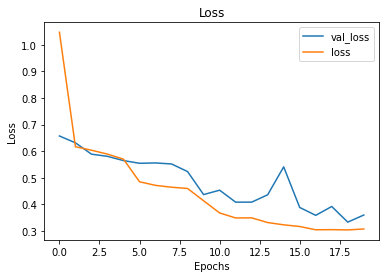

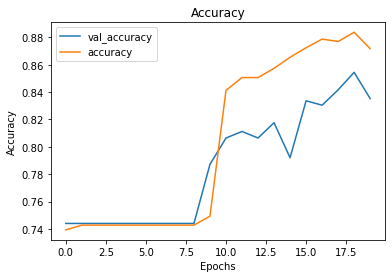

In [113]:
# Plot Loss and Accuracy
visualize_training_results(history_4)

In [131]:
# Generate predictions
predictions = model_4.predict(test_images)
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [135]:
cm_4 = confusion_matrix(test_labels, y_pred)
cm_4

array([[157,  77],
       [ 25, 365]])

In [ ]:
import itertools

In [138]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [134]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[157  77]
 [ 25 365]]


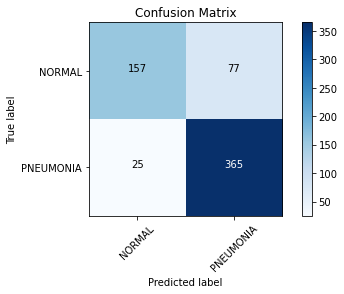

In [136]:
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm_4, classes=cm_plot_labels, title='Confusion Matrix')

In [137]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.86      0.67      0.75       234
Pneumonia (Class 1)       0.83      0.94      0.88       390

           accuracy                           0.84       624
          macro avg       0.84      0.80      0.82       624
       weighted avg       0.84      0.84      0.83       624



### Model 5  - Regularization of Model_4

In [83]:
#Instantiate a CNN model

from keras.layers import BatchNormalization

model_5 = Sequential()

# Apply 4 Convolution with Maxpooling with regularization: Dropouts, L2, Normalization

#Layer1
model_5.add(Conv2D(32, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))
model_5.add(MaxPooling2D(pool_size=(2, 2), padding = 'same', strides = 2))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())

#Layer2
model_5.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))
model_5.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())

#Layer3

model_5.add(Conv2D(128, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))
model_5.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())

#Layer4

model_5.add(Conv2D(256, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))
model_5.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())

# Flatten the model

model_5.add(Flatten())

# Add dense layers

model_5.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), activation = 'relu'))
model_5.add(Dropout(0.2))

# Add the output layer for binary - normal or pneumonia

model_5.add(Dense(1, activation = 'sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [84]:
model_5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 38, 38, 64)       

In [85]:
history_5 = model_5.fit(train_generator, 
                       epochs = 30, 
                       validation_data=val_generator)

Epoch 1/30
144/144 [==============================] - 128s 892ms/step - loss: 2.8165 - accuracy: 0.8445 - val_loss: 8.4723 - val_accuracy: 0.7440
Epoch 2/30
144/144 [==============================] - 130s 903ms/step - loss: 1.8051 - accuracy: 0.8610 - val_loss: 10.1352 - val_accuracy: 0.7440
Epoch 3/30
144/144 [==============================] - 127s 883ms/step - loss: 1.2511 - accuracy: 0.8954 - val_loss: 6.7103 - val_accuracy: 0.7440
Epoch 4/30
144/144 [==============================] - 127s 885ms/step - loss: 0.8452 - accuracy: 0.8874 - val_loss: 0.9628 - val_accuracy: 0.7648
Epoch 5/30
144/144 [==============================] - 137s 949ms/step - loss: 0.6454 - accuracy: 0.9020 - val_loss: 5.1119 - val_accuracy: 0.7440
Epoch 6/30
144/144 [==============================] - 136s 944ms/step - loss: 0.5705 - accuracy: 0.8985 - val_loss: 0.8240 - val_accuracy: 0.7968
Epoch 7/30
144/144 [==============================] - 137s 948ms/step - loss: 0.6021 - accuracy: 0.9033 - val_loss: 0.6476 

In [86]:
results_5_train = model_5.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 993us/step - loss: 0.5251 - accuracy: 0.8125


In [87]:
results_5_test = model_5.evaluate(test_images, test_labels)

20/20 [==============================] - 3s 158ms/step - loss: 0.6598 - accuracy: 0.7869


In [88]:
results_5_val = model_5.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 993us/step - loss: 0.5486 - accuracy: 0.8125


#### Evaluate Model 5

In [146]:
#Print results for Model 5 train and test
print("Model 4 Results from Training Data:", results_5_train)
print()
print("Model 3 Results from Test Data:", results_5_test)

Model 4 Results from Training Data: [0.5250768661499023, 0.8125]

Model 3 Results from Test Data: [0.6598176956176758, 0.7868589758872986]


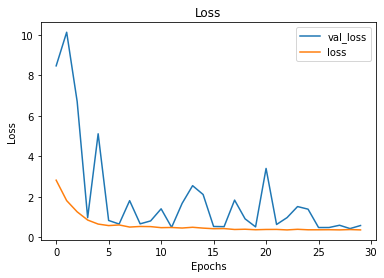

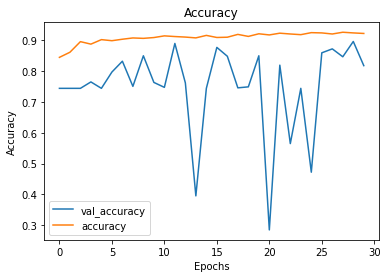

In [89]:
visualize_training_results(history_5)

In [139]:
# Generate predictions on test set
predictions = model_5.predict(test_images)

#y_hat_test = np.argmax(predictions, axis = 1)
# or
#np.round(predictions)


In [140]:
predictions[:10]

array([[0.96565765],
       [0.6013738 ],
       [0.53812903],
       [0.8112271 ],
       [0.99662995],
       [0.22664464],
       [0.417014  ],
       [0.96996474],
       [0.95272684],
       [0.83555496]], dtype=float32)

In [141]:
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [142]:
cm_5 = confusion_matrix(test_labels, y_pred)
cm

array([[157,  77],
       [ 25, 365]])

In [143]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[150  84]
 [ 49 341]]


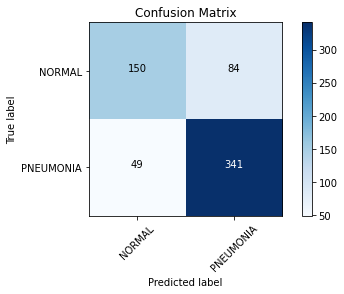

In [144]:

cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm_5, classes=cm_plot_labels, title='Confusion Matrix')

In [145]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.75      0.64      0.69       234
Pneumonia (Class 1)       0.80      0.87      0.84       390

           accuracy                           0.79       624
          macro avg       0.78      0.76      0.76       624
       weighted avg       0.78      0.79      0.78       624



## Model Evaluation


In [193]:

#model_1.save_weights('model_1.h5')
final_model = model_4

## Recommendations